In [2]:
import warnings
# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

#결과 여러개 뜨게 하기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats


import arch

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


In [4]:
#시계열 데이터 형식 맞춤(주기와 날짜)
weekly_oil = pd.read_excel('TAF_3_Modelling_Volatility_PES_oil.xls',index_col=0)
weekly_oil.index = pd.to_datetime(weekly_oil.index)
weekly_oil.index.freq = 'W-FRI'

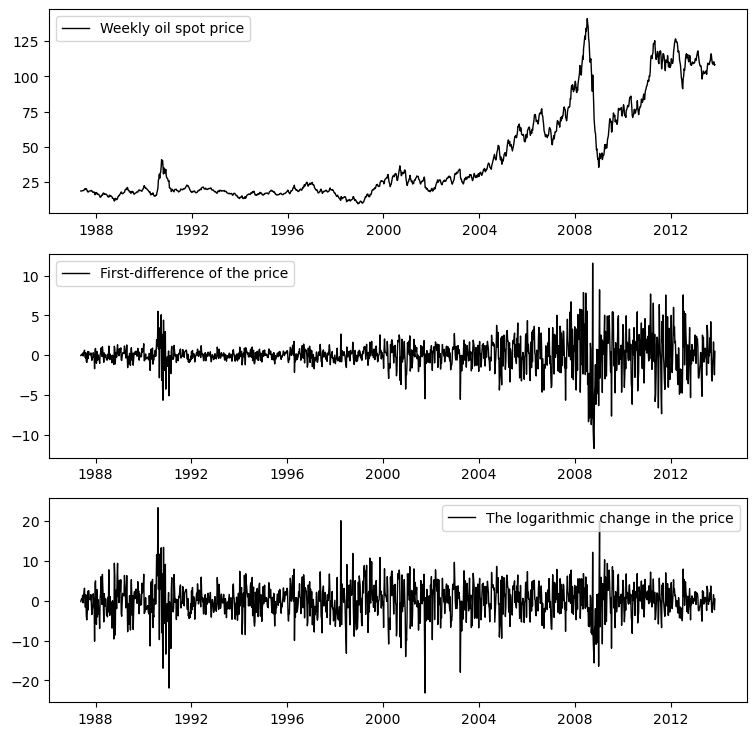

In [5]:
f, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(9, 3*3))
axes[0].plot(weekly_oil, color='black', linewidth=1, label='Weekly oil spot price')
axes[0].legend()

axes[1].plot(weekly_oil.diff(), color='black', linewidth=1, label='First-difference of the price')
axes[1].legend()

axes[2].plot(np.log(weekly_oil/weekly_oil.shift(1))*100, color='black', linewidth=1, label='The logarithmic change in the price')
axes[2].legend()

plt.show()

In [6]:
def adf_test(dataframe):
    result = adfuller(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    
    print(f'Critical values: {result[4]}')
    
adf_test(weekly_oil)
print('---'*40)
adf_test(weekly_oil.diff().dropna())
print('---'*40)
adf_test(np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100)


Statistics: -1.1354866114313127
p-value: 0.7007148498766298
Critical values: {'1%': -3.4351321860409674, '5%': -2.863651979448174, '10%': -2.567894416324791}
------------------------------------------------------------------------------------------------------------------------
Statistics: -9.970477287647244
p-value: 2.247373543623034e-17
Critical values: {'1%': -3.4351321860409674, '5%': -2.863651979448174, '10%': -2.567894416324791}
------------------------------------------------------------------------------------------------------------------------
Statistics: -17.180926385469355
p-value: 6.647698576457988e-30
Critical values: {'1%': -3.4351078301822016, '5%': -2.8636412316027577, '10%': -2.5678886927682663}


In [7]:
def kpss_test(dataframe):
    result = kpss(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'p-value: {result[1]}')

    print(f'Critical values: {result[3]}')

kpss_test(weekly_oil)
print('---'*40)
kpss_test(weekly_oil.diff().dropna())
print('---'*40)
kpss_test(np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100)


Statistics: 4.850221989568525
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.08440189249882568
p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.07035420343048165
p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_12675/125175154.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataframe)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_12675/125175154.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)
/var/folders/ws/lngrb3y14bx9ckr9196sk6qm0000gn/T/ipykernel_12675/125175154.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)


## ACF와 PACF 확인

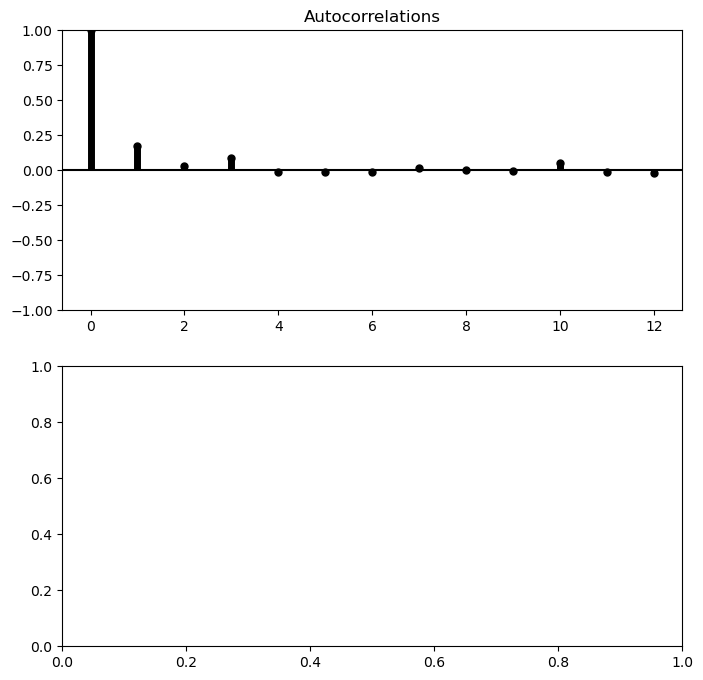

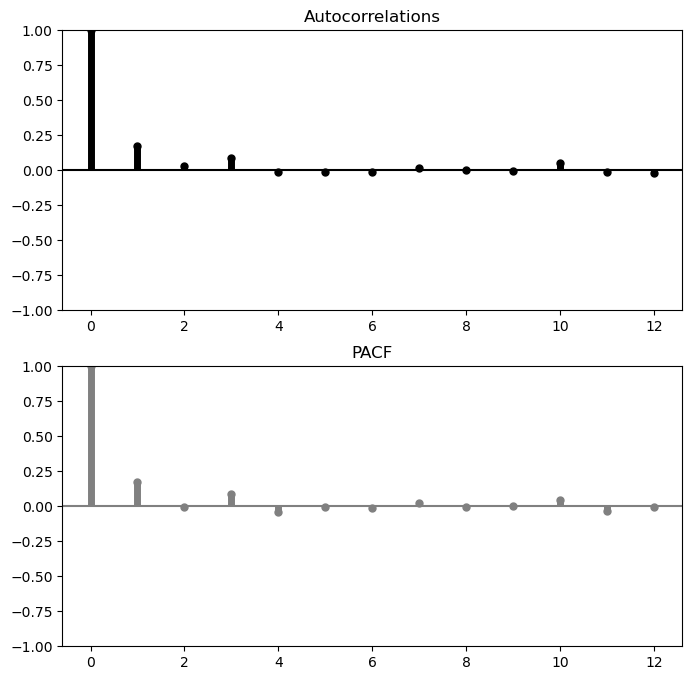

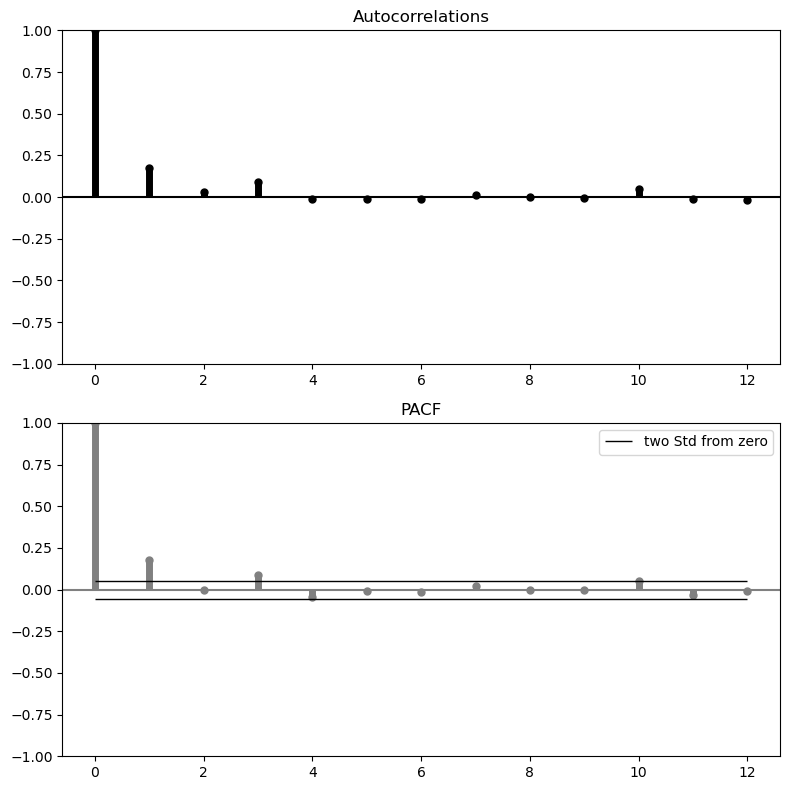

In [8]:

log_change = np.log(weekly_oil/weekly_oil.shift(1)).dropna()*100
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(log_change, lags=12, ax=axes[0], title= 'Autocorrelations', color='black', vlines_kwargs={'color': 'black','linewidth': 5},alpha=None)
plot_pacf(log_change, lags=12, ax=axes[1], method='ols',title= 'PACF', color='gray', vlines_kwargs={'color': 'gray','linewidth': 5},alpha=None)
axes[1].hlines(xmin=0,xmax=12, y=2*np.sqrt(1/len(log_change)),label='two Std from zero', color='black', linewidth=1)
axes[1].hlines(xmin=0,xmax=12, y=-2*np.
               sqrt(1/len(log_change)), color='black', linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()


In [9]:
res_1 = ARIMA(endog = log_change, order = (0,0,[1,3]), trend='c').fit(method='innovations_mle')
print('MA([1,3])')
for param_name, param in zip(res_1.params.index, res_1.params):
    coef = round(param,2)
    t_stats = round(res_1.tvalues[param_name],2)
    print(f'[{param_name}] = coef: {coef} , t_stats: {t_stats}')
    
residuals = res_1.resid
acf_d = acf(residuals, nlags=8)[1:]
print('ACF of the residuals')
print(acf_d)

squared_resids = residuals**2
acf_d_2 = acf(residuals, nlags=8)[1:]
print('ACF of the squared residuals')
print(acf_d_2)


MA([1,3])
[const] = coef: 0.13 , t_stats: 0.9
[ma.L1] = coef: 0.18 , t_stats: 9.31
[ma.L3] = coef: 0.09 , t_stats: 4.6
[sigma2] = coef: 16.98 , t_stats: 41.3
ACF of the residuals
[ 0.00189866  0.01249435 -0.00166611 -0.00924516 -0.0133628  -0.00787883
  0.01006452  0.00517871]
ACF of the squared residuals
[ 0.00189866  0.01249435 -0.00166611 -0.00924516 -0.0133628  -0.00787883
  0.01006452  0.00517871]


In [10]:
print('the MecLeod-Li test')
print(sm.stats.acorr_ljungbox(squared_resids, lags=[1,2,3,4,5,6,7,8]))
res_2 = ARIMA(endog = squared_resids, order=(4,0,0), trend='c').fit(method='innovations_mle')
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0)'
# This tests that each coefficient is jointly statistically significantly different from zero. 
print(res_2.f_test(hypotheses))

for param_name, param in zip(res_2.params.index, res_2.params): 
    coef = round(param,2)
    t_stats = round(res_2.tvalues[param_name],2) 
    print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')

the MecLeod-Li test
      lb_stat     lb_pvalue
1   46.136166  1.103132e-11
2   85.481014  2.741787e-19
3  113.516861  1.920320e-24
4  148.803145  3.674414e-31
5  169.879347  7.741852e-35
6  199.264797  2.720744e-40
7  244.066251  5.072476e-49
8  274.538260  1.068728e-54
<F test: F=75.96637995919032, p=nan, df_denom=inf, df_num=4>
[const] = coef:16.94, t_stats:4.99
[ar.L1] = coef:0.13, t_stats:8.05
[ar.L2] = coef:0.11, t_stats:8.0
[ar.L3] = coef:0.08, t_stats:5.03
[ar.L4] = coef:0.11, t_stats:6.63
[sigma2] = coef:1343.81, t_stats:83.25


In [11]:
# Fitting GARCH(1,1) model
res_3 = ARIMA(endog = log_change, order=(0,0,1), trend='c').fit(method='innovations_mle')
print('A MA(1) conditional mean model')
for param_name, param in zip(res_3.params.index, res_3.params):
    coef = round(param,2)
    t_stats = round(res_3.tvalues[param_name],2) 
    print(f'[{param_name}] = coef:{coef}, t_stats:{t_stats}')
model = arch.arch_model(res_3.resid, vol = 'GARCH',p = 1,q = 1)
garch_results = model.fit(disp = 'off', show_warning = False)
print(garch_results.summary())

A MA(1) conditional mean model
[const] = coef:0.13, t_stats:0.97
[ma.L1] = coef:0.18, t_stats:9.6
[sigma2] = coef:17.14, t_stats:41.61
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3796.10
Distribution:                  Normal   AIC:                           7600.19
Method:            Maximum Likelihood   BIC:                           7621.12
                                        No. Observations:                 1381
Date:                Tue, Oct 10 2023   Df Residuals:                     1380
Time:                        22:28:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------

In [22]:
garch_results.conditional_volatility[-5:-1]**2

Date
2013-10-04    6.436786
2013-10-11    6.087272
2013-10-18    5.968238
2013-10-25    5.686102
Freq: W-FRI, Name: cond_vol, dtype: float64

In [17]:
forecast = garch_results.forecast(horizon=5)
forecast.variance[-1:]

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2013-11-01,5.686465,5.961368,6.23053,6.494072,6.75211


In [13]:
# ACF of the standardized residuals and standardlized squared residuals
garch11_std_resid = garch_results.std_resid
acf_d = acf(garch11_std_resid, nlags=8)[1:]
print('ACF of the std residuals')
print(acf_d)
acf_d = acf(garch11_std_resid**2, nlags=8)[1:]
print('ACF of the squared std residuals')
print(acf_d)
print(sm.stats.acorr_ljungbox(garch11_std_resid, lags=[4,8]))
print(sm.stats.acorr_ljungbox(garch11_std_resid**2, lags=[4,8]))

ACF of the std residuals
[ 0.05529489 -0.00389773  0.04059871 -0.01441606 -0.03350124 -0.02191025
 -0.00327688 -0.01314317]
ACF of the squared std residuals
[-0.0003073   0.00511315 -0.00211738 -0.00583716 -0.02512703 -0.01331424
 -0.01228584  0.00200178]
    lb_stat  lb_pvalue
4  6.825416   0.145407
8  9.305283   0.317201
    lb_stat  lb_pvalue
4  0.089814   0.999021
8  1.427791   0.993843


In [14]:
res_ar4 = ARIMA(endog = garch11_std_resid, order=(4,0,0), trend='c').fit(method='innovations_mle') 

In [15]:
hypotheses = '(ar.L1 = 0), (ar.L2 = 0), (ar.L3 = 0), (ar.L4 = 0)'
# This tests that each coefficient is jointly statistically significantly␣↪different from zero. 
print(res_ar4.f_test(hypotheses))

<F test: F=1.8686521148468496, p=nan, df_denom=inf, df_num=4>
